# Example of a Modelling process

In this notebook, originally derived from the solutions to a test I created for a previous data analysis course, I work through a _"complete"_ solution to fitting a machine learning model to a dataset. I say "complete" here with a recognition to the incredible amount of bias that brings to the conversation. The data modelling process is nuanced and varied from data set to data set, so it's more important to interpret this as _an_ example rather than _the_ example.

We begin by importing our standard data libraries and loading the data.

In [1]:
from itertools import combinations, chain
from statistics import mean, median

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

%matplotlib inline

plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("data/test.csv", index_col=0)
df.head()

,default,student,balance,income,rent
1,No,No,729.526495,44361.625074,1382.367143
2,No,Yes,817.180407,12106.134700,677.912047
3,No,No,1073.549164,31767.138947,1589.497127
4,No,No,529.250605,35704.493935,1245.529318
5,No,No,785.655883,38463.495879,1195.162718


So, what we see here is a dataset used to predict whether or not someone will default on a loan, presumably given to them by a bank. The features of this data set are:

* `student`: whether or not the person was a student at the time of taking out a loan,
* `balance`: the balance they kept (unpaid) on their credit card each month, averaged over the course of the last year,
* `income`: annual income,
* `rent`: monthly rent or mortgage payment,
* `default` (**response**): whether or not they eventually defaulted on the loan they received (that is, failed to pay it back).

The goal of this machine learning exercise is to create a model that most effectively predicts whether or not a new loan applicant would default on their loan.

It's important to note, however, that while this data set might have originated from another source, I modified it heavily for the purposes of this exam.

## Cleaning data

First, we need to clean up the data by making the binary columns `1` and `0` and by dealing with any missing data.

In [3]:
df[df.isnull().any(axis=1)]

,default,student,balance,income,rent


So, there are no `NaN` values. However, there may still be missing values. Let's take a look at some statistics for the data set.

In [4]:
df.describe()

,balance,income,rent
count,10000.000000,10000.000000,10000.000000
mean,835.374886,33373.653962,1376.125732
std,483.714985,13483.531712,434.324628
min,0.000000,-1.000000,-214.053970
25%,481.731105,21221.387536,1070.117863
50%,823.636973,34495.956945,1378.045450
75%,1166.308386,43749.954675,1681.590985
max,2654.322576,73554.233495,2921.464501


Okay, so there are 10,000 rows in the data set. The minimum `balance` is `0`, which makes sense. The minimum `income` is `-1`, which seems wrong to me. Perhaps that's missing data. The minimum `rent` is `-214.053970`, which seems much weirder. Perhaps rent has been somehow normalized? But it that's so, then why is the median value of `rent` equal to `1378`? This number strikes me as a little high, but still a reasonable un-normalized value. So, the `rent` column is immediately suspect. However, let's continue to press on with this knowledge. Let's look at the counts of entries in the categorical columns, in some sense the equivalent of `describe`: 

In [5]:
print("default", df.default.value_counts(), sep="\n", end="\n\n")
print("student", df.student.value_counts(), sep="\n", end="\n\n")

default
No     9667
Yes     333
Name: default, dtype: int64

student
No            7048
Yes           2935
 student         9
no_student       8
Name: student, dtype: int64



Okay, so `default` looks good, but `student` looks problematic. There are 17 weirdly recorded entries, maybe those were captured by someone else? Let's assume that they were correct data that was simply misrecorded. We'll now create some new columns that _binarize_, or turn into `1` and `0`, those two columns.

In [6]:
binarizer = {'No': 0, 'Yes': 1, ' student': 1, 'no_student': 0} # works for both!

df['default_bin'] = df.default.map(binarizer)
df['student_bin'] = df.student.map(binarizer)

df.head()

,default,student,balance,income,rent,default_bin,student_bin
1,No,No,729.526495,44361.625074,1382.367143,0,0
2,No,Yes,817.180407,12106.134700,677.912047,0,1
3,No,No,1073.549164,31767.138947,1589.497127,0,0
4,No,No,529.250605,35704.493935,1245.529318,0,0
5,No,No,785.655883,38463.495879,1195.162718,0,0


Okay, so I think the categorical columns are cleaned. Now, let's move on to exploring those negative values for `income` and `rent`. First, let's look at some histograms.

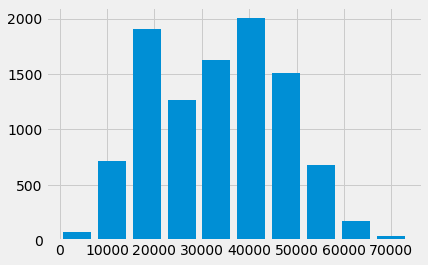

In [7]:
# What's that -1 for income?

plt.hist(df.income, rwidth=0.8)
plt.show()

That isn't very illustrative. Let's enhance it to have more boxes. I'm suspecting that perhaps `-1` would make sense for missing values.

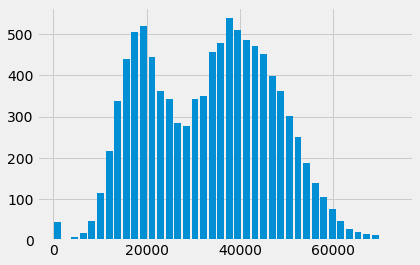

In [8]:
plt.hist(df.income, bins=40, rwidth=0.8)
plt.show()

Okay, presumably that chunk that's separatated away from the rest of the values are all missing. Are they all `-1`?

In [9]:
df[df.income < 100]

,default,student,balance,income,rent,default_bin,student_bin
528,No,No,761.064098,-1.0,2014.861187,0,0
853,No,No,683.357394,-1.0,1110.388560,0,0
930,No,No,1166.642625,-1.0,2229.347577,0,0
1040,No,No,1386.302444,-1.0,2175.382787,0,0
1244,No,No,935.481005,-1.0,1920.431460,0,0
1506,No,No,111.294954,-1.0,1472.555036,0,0
1528,No,No,392.239540,-1.0,1766.259048,0,0
1650,No,Yes,711.030496,-1.0,1235.572228,0,1
2240,No,No,159.973473,-1.0,1399.759728,0,0
2251,No,No,1311.088803,-1.0,1075.141242,0,0


Okay, so anything that's less than `100` is in fact equal to `-1`. I'm going to definitely interpret those as missing data. I want to fill them in, but I'm now suspicious of that double peak in the middle of the `income` distribution. Since `student` is a possible option in the dataset, I'm going to see if I can explain the double peak in `income` by splitting across `student`.

In [10]:
# Save these indices to check later:
bad_income_rows = df[df.income < 100].index

student_median_income = df[df.student_bin == 1].income.median()
non_student_median_income = df[df.student_bin == 0].income.median()

# Are they different?
print("Student median income:", 
      student_median_income, 
      "\nNon-student median income:",
      non_student_median_income)

Student median income: 17962.2906234375 
Non-student median income: 39829.754224847304


Okay, so the median income is definitely affected by whether someone is a student. Is this the explanation for the weird distribution?  If so, then filling with these medians-split-by-`student` seems like a good idea.

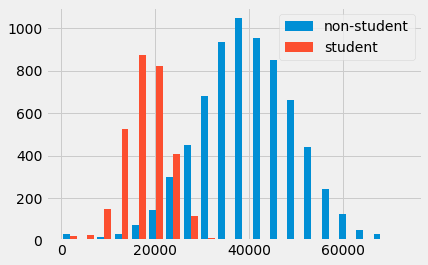

In [11]:
students = df[df.student_bin == 1]
non_students = df[df.student_bin == 0]

plt.hist([non_students.income, students.income],  
         label=['non-student', 'student'], 
         bins=20)
plt.legend()
plt.show()

Now _that's_ a satisfying graph. Those two colors of histograms are normal-looking enough that I'm feeling very confident that the `income` and `student` columns make sense to me, and work nicely together. I'm also feeling confident that I should be able to fill the missing values in `income` with their medians-split-by-`student`.

In [12]:
def income_filler(row):
    """ Making this method because the lambda would be a bit clumbsy-looking."""
    if row['income'] != -1.0:
        return row['income']
    if row['student_bin'] == 1:
        return student_median_income
    return non_student_median_income

df.income = df.apply(income_filler, axis=1)
df.loc[bad_income_rows][:10]

,default,student,balance,income,rent,default_bin,student_bin
528,No,No,761.064098,39829.754225,2014.861187,0,0
853,No,No,683.357394,39829.754225,1110.388560,0,0
930,No,No,1166.642625,39829.754225,2229.347577,0,0
1040,No,No,1386.302444,39829.754225,2175.382787,0,0
1244,No,No,935.481005,39829.754225,1920.431460,0,0
1506,No,No,111.294954,39829.754225,1472.555036,0,0
1528,No,No,392.239540,39829.754225,1766.259048,0,0
1650,No,Yes,711.030496,17962.290623,1235.572228,0,1
2240,No,No,159.973473,39829.754225,1399.759728,0,0
2251,No,No,1311.088803,39829.754225,1075.141242,0,0


That's done. I'm feeling good about `income`, `student`, and `default`. And I also learned that if we include `income`, we'd better include `student`, too.

Now, let's take a look at `rent`.

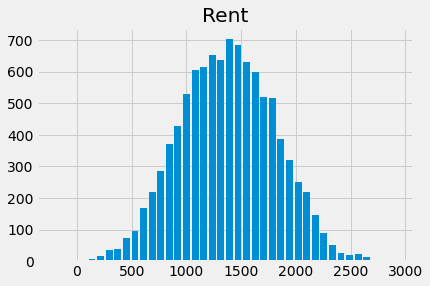

In [13]:
# Now, on to rent:
plt.hist(df.rent, bins=40, rwidth=0.8)
plt.title('Rent');

Okay, that looks very normally distributed. However, it goes all the way down to negative values. If it had the same mean but a smaller standard deviation, I would believe it, but it almost looks fake to me, given how far down in values it goes. Let's zoom in on those small values.

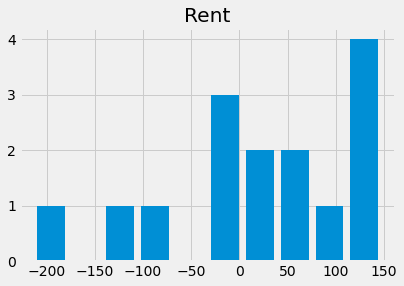

In [14]:
plt.hist(df.rent[df.rent < 150], rwidth=0.8)
plt.title('Rent')
plt.show()

This further suggests to me that rent is a garbage column. It's extremely normal-looking, and has some negative values that don't fit with what rent could possibly mean. I'm skeptical of it.

Finally, let's look at `balance`.

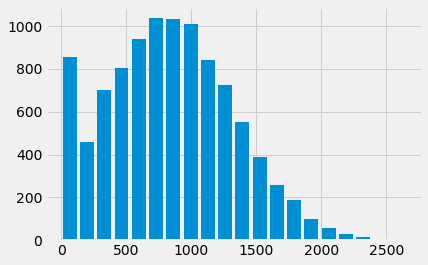

In [15]:
# Just checking, for good measure:
plt.hist(df.balance, bins=20, rwidth=0.8)
plt.show()

I like this column. It seems reasonable that there are lots of people that keep a credit card balance of actually zero, and then something close to a normal-looking distribution beyond that. Let's see what it looks like without those folks who pay off their balance every month:

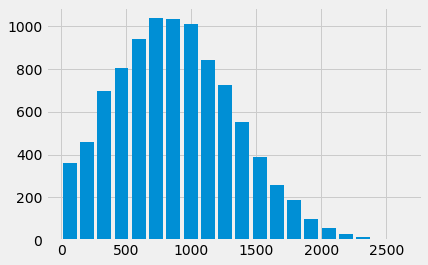

In [16]:
plt.hist(df.balance[df.balance > 0], bins=20, rwidth=0.8)
plt.show()

This confirms my suspicions, as it looks even closer to normal (and doesn't go negative like `rent` does).

At this point, I think our data is properly cleaned. Let's move on.

## Scatterplots and choosing good predictors

Now, what I want to take a look at is the quality of each predictor against the response of `default`. On the outset, I could imagine any of these predictors being decent at predicting loan default, but let's see what the numbers show.

There are so many non-defaulters in the dataset that I'm going to make them more transparent, so that I can really see the default entries.

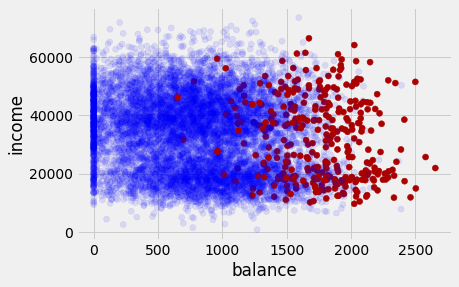

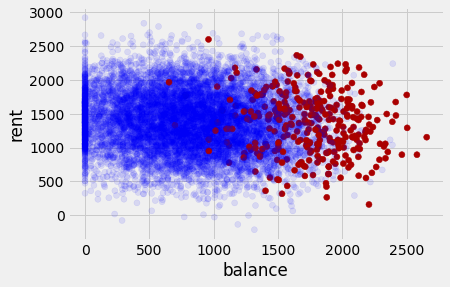

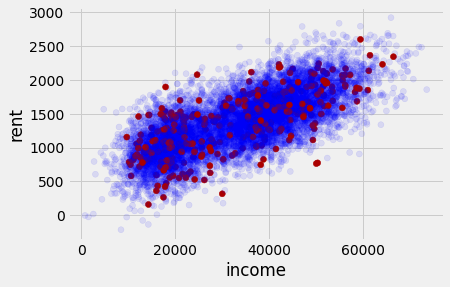

In [17]:
colormap = {1:'#aa0000', 0:'b'}
preds = ['balance', 'income', 'rent']
for x,y in (combinations(preds,2)):
    plt.scatter(df[x], df[y], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

Okay, so for the third time, rent is definitely not predictive, and is possibly a garbage column anyway. I'm going to not include it in my models, as it will only add noise. Personally, I don't think `income` is very predictive either, but balance seems quite predictive.  Let's create two models: `['balance', 'income', 'student_bin']` and just `'balance'`, and we'll test them both to see which fits the data better.

You could certainly create even more models and test them, but my above analysis suggests that one of these should be the best.

## Fitting and testing models 

We now fit our models, after splitting off some test data.

In [18]:
from sklearn.model_selection import train_test_split

model_1_preds = ['balance', 'income', 'student_bin'] 

X_train, X_test, y_train, y_test = train_test_split(df[model_1_preds], df.default_bin, test_size=.3)

One important check here: there are very few 1's in the `default` column, which makes sense. However, we want to make sure that some of those will be in the test data, because otherwise we won't be testing our models fairly. Also, I suspect that it's much more important to correctly predict whether someone will default than if someone won't. In other words, false negatives are far worse than false positives. So, we need to ensure that some positives are in the test data.

I can't remember whether scikit-learn's `train_test_split` balances the classes by default, so let's count:

In [19]:
number_of_training_positives = y_train[y_train == 1].count()
number_of_testing_positives = y_test[y_test == 1].count()
print(number_of_testing_positives, number_of_training_positives)

94 239


That looks great. Scikit-learn must have balanced the classes. Let's fit our models.

In [20]:
model_1 = LogisticRegression().fit(X_train, y_train)
model_2 = LogisticRegression().fit(X_train[['balance']], y_train) # Wrap double brackets or reshape(-1,1)

That cell is always so anticlimactic. Anyways, let's test out our models and see which is best.

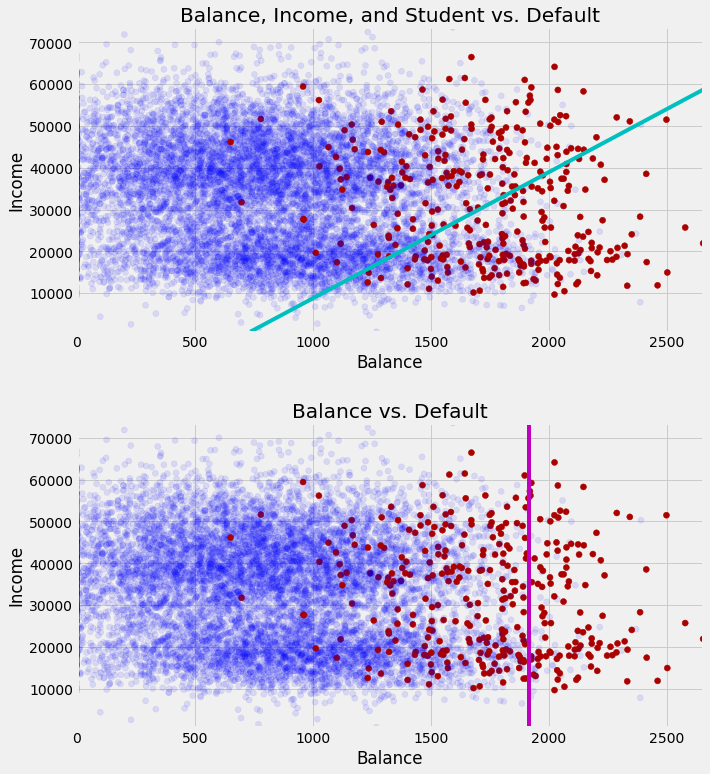

In [21]:
X_data = df[model_1_preds].values

x_axis_name = 'balance'
y_axis_name = 'income'

# CONSTANTS
GRANULARITY = 50

#### CREATE PREDICTION SURFACES ####
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

X_columns_1 = np.c_[xx1_col, xx2_col, np.zeros(xx1_col.shape)]
X_columns_2 = np.c_[xx1_col]

yy_1 = model_1.predict_proba(X_columns_1).T[0]
yy_1 = yy_1.reshape(xx1.shape)

yy_2 = model_2.predict_proba(X_columns_2).T[0]
yy_2 = yy_2.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure(figsize=(10,12))
figure.subplots_adjust(hspace=.3) # This line adds some space between plots

## Model 1
ax1 = figure.add_subplot(2,1,1)

ax1.set_xlim(x1_min, x1_max)
ax1.set_ylim(x2_min, x2_max)
ax1.set_xlabel('Balance')
ax1.set_ylabel('Income')
ax1.set_title('Balance, Income, and Student vs. Default')

ax1.contour(xx1, xx2, yy_1, levels=[.5], colors=['c'])
ax1.scatter(df[x_axis_name],df[y_axis_name], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])

## Model 2
ax2 = figure.add_subplot(2,1,2)

ax2.set_xlim(x1_min, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_xlabel('Balance')
ax2.set_ylabel('Income')
ax2.set_title('Balance vs. Default')

ax2.contour(xx1, xx2, yy_2, levels=[.5], colors=['m'])
ax2.scatter(df[x_axis_name],df[y_axis_name], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])

plt.show()

Okay, this doesn't look great to me. It's important to note a few things that we can do to improve this model:

* This might be happening because we need to normalize/standardize the dataset.
* There are so many non-defaulters that they're skewing the model toward more false negatives, which is a problem.

We'll start by normalizing the data.

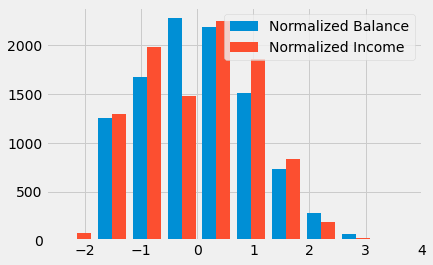

In [22]:
df['income_norm'] = (df.income - df.income.mean())/df.income.std()
df['balance_norm'] = (df.balance - df.balance.mean())/df.balance.std()

# To check, let's look at a histogram
plt.hist([df.balance_norm, df.income_norm], label=['Normalized Balance', 'Normalized Income'])
plt.legend()
plt.show()

These look fine to me. Let's resplit the data now that we have these normalized columns, and then refit.

In [23]:
model_1_preds_norm = ['balance_norm', 'income_norm', 'student_bin'] 
X_train, X_test, y_train, y_test = train_test_split(df[model_1_preds_norm], df.default_bin, test_size=.3)

model_1_norm = LogisticRegression().fit(X_train, y_train)
model_2_norm = LogisticRegression().fit(X_train[['balance_norm']], y_train)

Let's try that graph again.

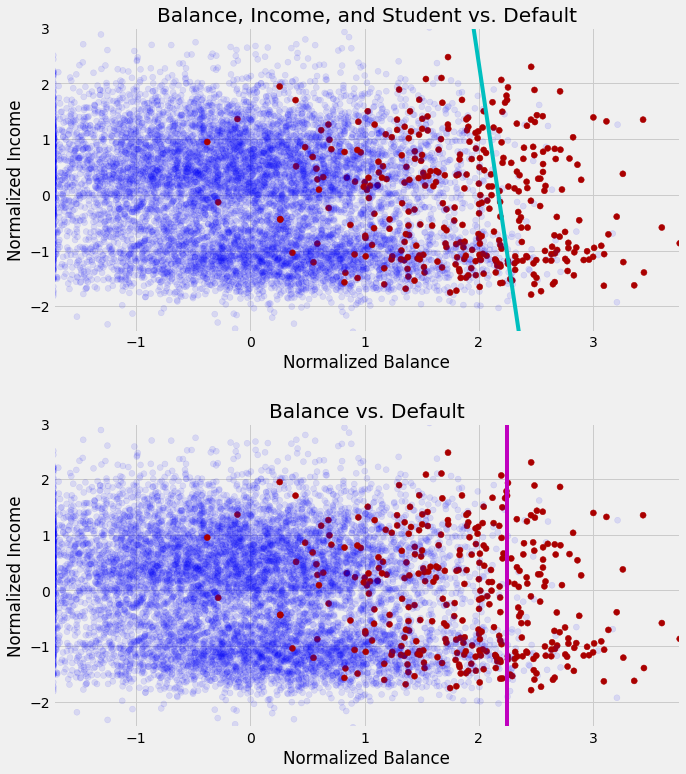

In [24]:
X_data = df[model_1_preds].values

x_axis_name = 'balance_norm'
y_axis_name = 'income_norm'

# CONSTANTS
GRANULARITY = 50

#### CREATE PREDICTION SURFACES ####
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

X_columns_1 = np.c_[xx1_col, xx2_col, np.zeros(xx1_col.shape)] # Just do non-student for the plot (that's the median)
X_columns_2 = np.c_[xx1_col]

yy_1 = model_1_norm.predict_proba(X_columns_1).T[0]
yy_1 = yy_1.reshape(xx1.shape)

yy_2 = model_2_norm.predict_proba(X_columns_2).T[0]
yy_2 = yy_2.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure(figsize=(10,12))
figure.subplots_adjust(hspace=.3) # This line adds some space between plots

## Model 1
ax1 = figure.add_subplot(2,1,1)

ax1.set_xlim(x1_min, x1_max)
ax1.set_ylim(x2_min, x2_max)
ax1.set_xlabel('Normalized Balance')
ax1.set_ylabel('Normalized Income')
ax1.set_title('Balance, Income, and Student vs. Default')

ax1.contour(xx1, xx2, yy_1, levels=[.5], colors=['c'])
ax1.scatter(df[x_axis_name],df[y_axis_name], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])

## Model 2
ax2 = figure.add_subplot(2,1,2)

ax2.set_xlim(x1_min, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_xlabel('Normalized Balance')
ax2.set_ylabel('Normalized Income')
ax2.set_title('Balance vs. Default')

ax2.contour(xx1, xx2, yy_2, levels=[.5], colors=['m'])
ax2.scatter(df[x_axis_name],df[y_axis_name], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])

plt.show()

Okay, it's *maybe* a bit better. I think the overwhelming number of non-defaulters is the real culprit. There are a few ways to deal with this:

* We could just adjust the cut-off point from .5 to a higher threshold.
* We could remove many of the non-defaulters.
* We could try to model the defaulters and draw from that model to create some fake data.

The latter two options seem less good to me, because of the huge imbalance. Before we make any changes, let's take a look at some metrics.

It's important to note that accuracy score is useless here, because a model which just predicts non-default for everyone would have an accuracy of something like 97%. By that metric, our models probably look worse:

In [25]:
all_zero_model_accuracy = df[df.default_bin ==0]["default"].count() / df.shape[0]

y_test_predictions_1 = model_1_norm.predict(X_test)
model_1_score = accuracy_score(y_test, y_test_predictions_1)
y_test_predictions_2 = model_2_norm.predict(X_test[["balance_norm"]])
model_2_score = accuracy_score(y_test, y_test_predictions_2)

print("model that predicts all non-default: {}".format(all_zero_model_accuracy))
print("model 1 accuracy: {}".format(model_1_score))
print("model 2 accuracy: {}".format(model_2_score))

model that predicts all non-default: 0.9667
model 1 accuracy: 0.9703333333333334
model 2 accuracy: 0.9696666666666667


Surprisingly, these models are actually _not_ a lot worse than the all-zeros model. However, if we use the confusion matrix to pay attention to false negatives specifically, we can have a better sense of the qualities of these models.

In [26]:
# This little function just makes it print out a little nicer, because it's not 100% 
# clear which entry is the false negatives
def print_confusion_matrix(model_info, y_predictions):
    matrix = confusion_matrix(y_test, y_predictions)
    print("{}: ".format(model_info), 
        matrix,
        "False negatives: {}".format(matrix[1,0]),
        sep='\n'
    )

print_confusion_matrix("Model 1 (Balance, Income, Student)", model_1_norm.predict(X_test))
print()
print_confusion_matrix("Model 2 (Balance only)", model_2_norm.predict(X_test[['balance_norm']]))

Model 1 (Balance, Income, Student): 
[[2888   16]
 [  73   23]]
False negatives: 73

Model 2 (Balance only): 
[[2886   18]
 [  73   23]]
False negatives: 73


So, what we want to do is look at what's called the "decision surface", or, the collection of all the "decision boundaries" if we were to chose different thresholds. This isn't a particularly useful picture, but it can help inform our change of threshold later.

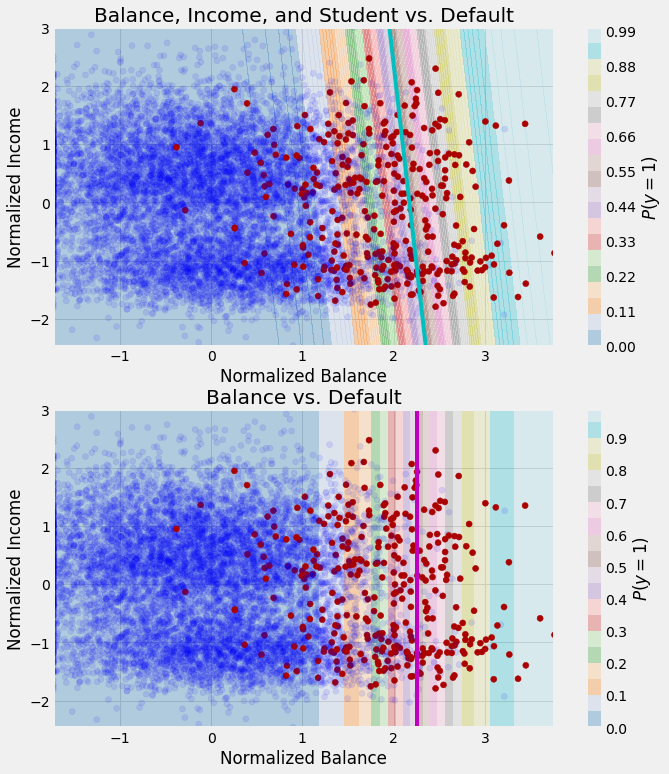

In [27]:
X_data = df[model_1_preds].values

x_axis_name = 'balance_norm'
y_axis_name = 'income_norm'

# CONSTANTS
GRANULARITY = 50

#### CREATE PREDICTION SURFACES ####
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

X_columns_1 = np.c_[xx1_col, xx2_col, np.zeros(xx1_col.shape)] # Just do non-student for the plot (that's the median)
X_columns_2 = np.c_[xx1_col]

yy_1 = model_1_norm.predict_proba(X_columns_1).T[0]
yy_1 = 1 - yy_1.reshape(xx1.shape)

yy_2 = model_2_norm.predict_proba(X_columns_2).T[0]
yy_2 = 1 - yy_2.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure(figsize=(10,12))

## Model 1
ax1 = figure.add_subplot(2,1,1)

ax1.set_xlim(x1_min, x1_max)
ax1.set_ylim(x2_min, x2_max)
ax1.set_xlabel('Normalized Balance')
ax1.set_ylabel('Normalized Income')
ax1.set_title('Balance, Income, and Student vs. Default')

ax1.contour(xx1, xx2, yy_1, levels=[.5], colors=['c'])
contour = ax1.contourf(xx1, xx2, yy_1, 100, cmap="tab20",
                      vmin=0, vmax=1, alpha=0.3)
ax1_c = figure.colorbar(contour) # Adds a colorbar, which is like a continuous legend
ax1_c.set_label("$P(y = 1)$") # Labels the above colorbar
ax1.scatter(df[x_axis_name],df[y_axis_name], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])

## Model 2
ax2 = figure.add_subplot(2,1,2)

ax2.set_xlim(x1_min, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_xlabel('Normalized Balance')
ax2.set_ylabel('Normalized Income')
ax2.set_title('Balance vs. Default')

ax2.contour(xx1, xx2, yy_2, levels=[.5], colors=['m'])
contour = ax2.contourf(xx1, xx2, yy_2, 100, cmap="tab20",
                      vmin=0, vmax=1, alpha=0.3)
ax2_c = figure.colorbar(contour) # Adds a colorbar, which is like a continuous legend
ax2_c.set_label("$P(y = 1)$") # Labels the above colorbar
ax2.scatter(df[x_axis_name],df[y_axis_name], c=df.default_bin.map(colormap), alpha=[1 if i==1 else 0.1 for i in df.default_bin])

plt.show()

It seems to me that adding `student` and `income` aren't really helping, so I'm choosing to stick with the `balance`-only model (Occam's razor).  Finally, we probably want to shift the decision boundary a bit, based on the fast that false negatives are far more important to us than false positives.

In [28]:
probabilities = model_2_norm.predict_proba(X_test[['balance_norm']])[:,1]

for cutoff in [.5, .4, .3, .2, .1, .05, .03, .01]:
    predictions = [1 if prob > cutoff else 0 for prob in probabilities]
    print_confusion_matrix("Model 2 (balance only), cutoff at {}".format(1 - cutoff), predictions)
    print()

Model 2 (balance only), cutoff at 0.5: 
[[2886   18]
 [  73   23]]
False negatives: 73

Model 2 (balance only), cutoff at 0.6: 
[[2877   27]
 [  64   32]]
False negatives: 64

Model 2 (balance only), cutoff at 0.7: 
[[2856   48]
 [  55   41]]
False negatives: 55

Model 2 (balance only), cutoff at 0.8: 
[[2818   86]
 [  44   52]]
False negatives: 44

Model 2 (balance only), cutoff at 0.9: 
[[2726  178]
 [  33   63]]
False negatives: 33

Model 2 (balance only), cutoff at 0.95: 
[[2585  319]
 [  21   75]]
False negatives: 21

Model 2 (balance only), cutoff at 0.97: 
[[2469  435]
 [  13   83]]
False negatives: 13

Model 2 (balance only), cutoff at 0.99: 
[[2148  756]
 [   6   90]]
False negatives: 6



And now that's for the hypothetical bank to decide, but I like a cutoff of `0.95`. It would look like this on the scatterplot:

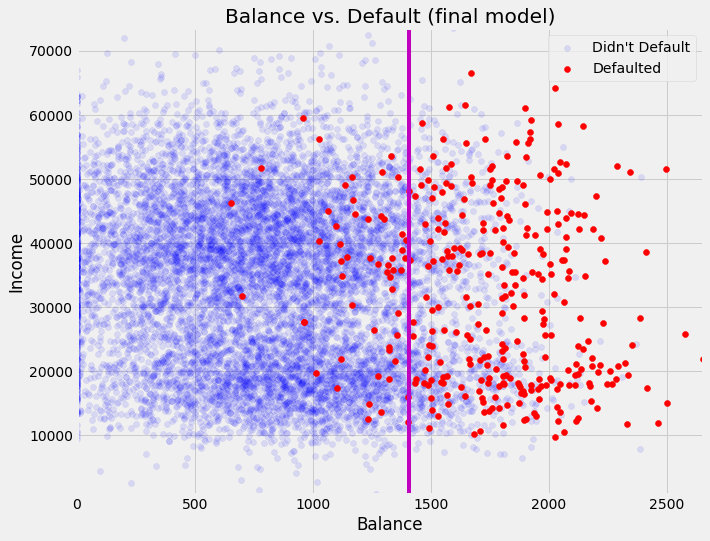

In [29]:
X_data = df[model_1_preds].values

x_axis_name = 'balance'
y_axis_name = 'income'

# CONSTANTS
GRANULARITY = 50

#### CREATE PREDICTION SURFACES ####
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

X_columns_1 = np.c_[xx1_col, xx2_col, np.zeros(xx1_col.shape)] # Just do non-student for the plot (that's the median)
X_columns_2 = np.c_[xx1_col]

yy_2 = model_2.predict_proba(X_columns_2).T[0]
yy_2 = yy_2.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure(figsize=(10,8))

## Model 1
ax2 = figure.add_subplot(1,1,1)

ax2.set_xlim(x1_min, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_xlabel('Balance')
ax2.set_ylabel('Income')
ax2.set_title('Balance vs. Default (final model)')

ax2.contour(xx1, xx2, yy_2, levels=[.95], colors=['m'])
# contour = ax2.contourf(xx1, xx2, yy_2, 100, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax2_c = figure.colorbar(contour) # Adds a colorbar, which is like a continuous legend
# ax2_c.set_label("$P(y = 1)$") # Labels the above colorbar

no_default = df[df.default_bin == 0]
default = df[df.default_bin == 1]

ax2.scatter(no_default[x_axis_name], no_default[y_axis_name], label='Didn\'t Default', c='b', alpha=0.1)
ax2.scatter(default[x_axis_name], default[y_axis_name], label='Defaulted', c='r')
plt.legend()

plt.show()

Or, we could plot a histogram, considering that we're not including income any more. We need to let the non-defaulters go off the top of the histogram a bit, otherwise they would overwhelm the graph and you wouldn't be able to see any defaulters.

We need to do a bit of work to compute the actual decision boundary given that we want the .95 threshold, rather than the .5 threshold.

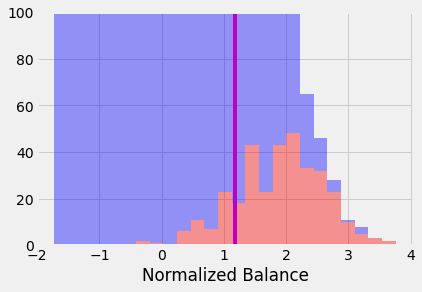

In [30]:
b = model_2_norm.intercept_[0]
m = model_2_norm.coef_[0][0]

# This is the logistic equation, solved for x:
normed_boundary = 1 / m * (np.log(.05/.95) - b)
#(There's probably a way to do this that doesn't involve doing this pencil-and-paper math...)

plt.hist([default["balance_norm"], no_default["balance_norm"]], bins=25, stacked=True, color=["red", "blue"], alpha=0.4)
plt.xlabel("Normalized Balance")
plt.ylim([0,100])
plt.plot([normed_boundary, normed_boundary], [0, 100], c="m");

In conclusion, we fit the model to only `balance`, had to work on some missing values a bit, we needed to change the threshold to something like `0.95`, and we feel we should write to the data set owner about how someone probably messed with the data to produce the `rent` column. I'm not sure how useful normalizing the data was, so we could always try without normalizing, but I like this model.